# ボケ判定AIを作ろう！-チュートリアル1
このnotebookは、Nishikaコンペティション [ボケ判定AIを作ろう！](https://www.nishika.com/competitions/) のチュートリアルです。

「ボケて」データを用いて、画像データと文章からそのボケてが面白いか面白くないかを予測することをテーマとしています。

このNotebookでは、画像とテキストそれぞれの特徴量生成を以下のような方法で行っていきます。

- CNNモデルを用いた画像データの特徴量化
- BERTモデルを用いたテキストデータの特徴量化

特徴量の作成では、テキストと画像それぞれ別々で作成していますので、画像データとテキストデータを組み合わせた特徴量を入れることで精度向上が見込めるかも知れませんので、いろいろと試していただければと思います。

| 要素 | 説明 |
| ---- | ---- |
|id | ID|
|odai_photo_file_name | ボケてのお題画像|
|text | ボケての文章|
|is_laugh | 面白さ（面白い：１、面白くない：０）|


ディレクトリ構成は以下のように設定します

```
├── train.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── test.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
└── submission.csv(今回のbaselineで生成されるsubmissionファイル)


```

### setting
ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

In [ ]:
!pip install tfswin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tfswin: filename=tfswin-3.1.0-py3-none-any.whl size=19220 sha256=20590d6fc96db0fe8e04152cd42efd54d37a89e18cfde77a4f256420875e3f1b
  Stored in directory: /root/.cache/pip/wheels/59/6b/2f/df987fb7de48d7712caed0ff1953644fa428c84a601e704e55
Successfully built tfswin


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Sep  5 12:09:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [ ]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 27.7 MB/s 
     |████████████████████████████████| 880 kB 57.2 MB/s 
     |████████████████████████████████| 120 kB 49.3 MB/s 
     |████████████████████████████████| 1.3 MB 4.3 MB/s 
     |████████████████████████████████| 4.1 MB 4.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch


from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Setting

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_image_path = "/content/drive/MyDrive/nishika/train/"
test_image_path = "/content/drive/MyDrive/nishika/test/"

# Read Data
学習データと推論データについて、目的変数の分布などを確認していきます。

In [ ]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [ ]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


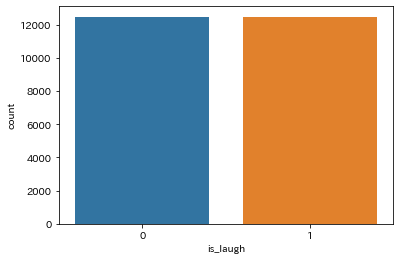

In [ ]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [ ]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


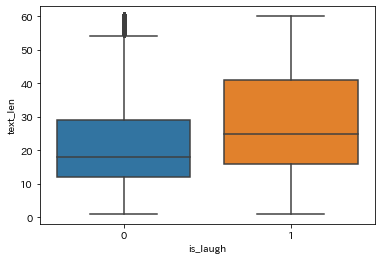

In [ ]:
# 文書の長さとflagの関係を確認する
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

sns.boxplot(x="is_laugh", y="text_len", data=train_df)

目的変数の分布と、文章の長さについて確認しました。続いて、実際に画像と文章を合わせてみてみましょう。

個人的な主観も含まれてしまいますが、以下のようなことがわかってきました。  
- ファイル名で確認すると、画像の重複はtrainとtestではない。
- ボケての文章の長さを確認すると、面白いボケての方が文章が長い傾向
- 画像とボケての文章を見てみると、確かに１と０で差がありそう（個人的に０の方はどのようにボケているのかが少しわかりにくい感じがあります）

今回は単純に文章の長さのみを確認しましたが、他にも文章自体について注目していくと、面白さに関する知見というのが見えてくるかも知れません。


# Create Image Features

ボケてというものは、画像と文章の組み合わせで面白さを表現しているので、以下にして画像のデータと文章のデータをモデルに学習させるかがポイントになってくるかと思います。

画像のデータを特徴量として用いるために、今回はDenseNet121の学習済みモデルを用います。

In [ ]:
import cv2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from tqdm import tqdm, tqdm_notebook
from tfswin import SwinTransformerV2Base256, preprocess_input

In [ ]:
class CFG:
    img_size = 256
    batch_size = 17

In [ ]:
def resize_to_square(im):
    old_size = im.shape[:2] 
    ratio = float(CFG.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # 画像サイズを256×256に変更します
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = CFG.img_size - new_size[1]
    delta_h = CFG.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im


def load_image(ids, is_train=True):
  if is_train:
    image = cv2.imread(train_image_path+ids)
  else:
    image = cv2.imread(test_image_path+ids)
  new_image = resize_to_square(image)
  new_image = preprocess_input(new_image)
  return new_image

In [ ]:
inp = Input((256,256,3))
backbone = SwinTransformerV2Base256(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

352149504/352141152 [==============================] - 44s 0us/step


In [ ]:
image_df_train = train_df[["id", "odai_photo_file_name"]].copy()
image_df_train.head()

,id,odai_photo_file_name
0,ge5kssftl,9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg


In [ ]:
image_ids = image_df_train["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1

In [ ]:
features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

  0%|          | 0/1469 [00:00<?, ?it/s]

Error


100%|██████████| 1469/1469 [4:50:26<00:00, 11.86s/it]


In [ ]:
image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("SwinTransformerV2Base256_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

In [ ]:
# trainのデータに結合します。
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")

In [ ]:
train_df.shape

(24962, 261)

In [ ]:
# testデータでも同様なことを行って行きます
image_df_test = test_df[["id", "odai_photo_file_name"]].copy()

image_ids = image_df_test["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1


features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id, is_train=False)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("SwinTransformerV2Base256_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

test_df = pd.merge(test_df, image_feature, on="odai_photo_file_name", how="left")

100%|██████████| 353/353 [1:08:23<00:00, 11.62s/it]


In [ ]:
test_df.shape

(6000, 260)

# Data Split

In [ ]:
train_df.to_csv('embedding_train_image_SwinTransformerV2Base256')

In [ ]:
test_df.to_csv('embedding_test_image_SwinTransformerV2Base256')

In [ ]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 257)
(4993, 257)


# Model

In [ ]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.625827	valid's binary_logloss: 0.668921
[100]	train's binary_logloss: 0.594954	valid's binary_logloss: 0.668366
[150]	train's binary_logloss: 0.568189	valid's binary_logloss: 0.668395
Early stopping, best iteration is:
[139]	train's binary_logloss: 0.573732	valid's binary_logloss: 0.66786


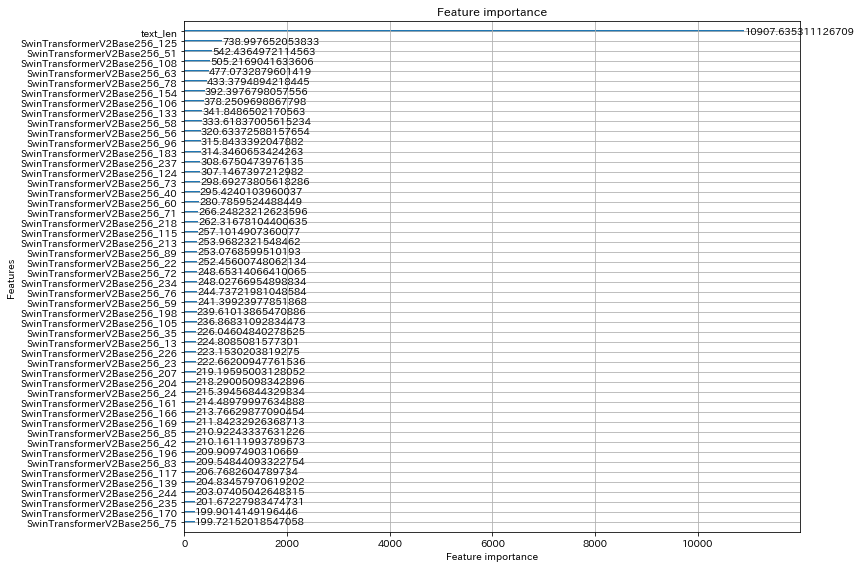

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.5902263168435811


Text(0.5, 52.0, 'Predict')

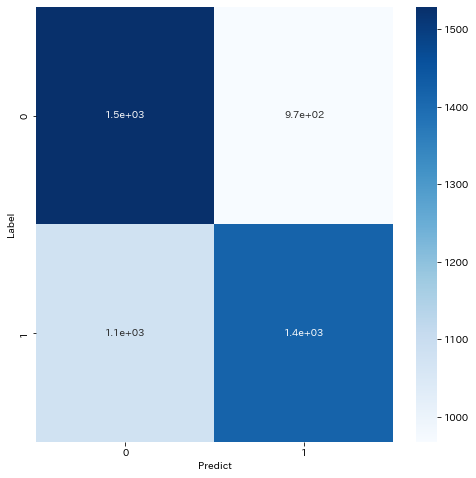

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.443320
1,tsgqmfpef,0.370633
2,owjcthkz2,0.387677
3,rvgaocjyy,0.505009
4,uxtwu5i69,0.691848


In [ ]:
submission_df.to_csv(('sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）


https://lab.mo-t.com/blog/kaggle-shopee
前処理については今回は気にしない。最終的なLightgbmにぶっこむ特徴量を増やして選別する方針でいく。
エンベッディングした結果は保存する。
最初は画像は画像、テキストはテキストでエンベッディングする。
画像のArcFaceちょっとめんどい、実装できそうならやる
knn(k=50)を使って、画像、テキストの分類自体はする。
https://www.kaggle.com/code/jyotmakadiya/shopee-groupkfolds-effnetb1-and-tfidf-or-bert

基本はエンベッディングしたものを使う。
プラスで、特徴量を足してみる。
乖離具合ってどうやって測定するのか
・長文？なんかキーになる話がある？画像と関係？わからん
・ボケのデザインパターン/ジョナサン・ハイト
・既知未知判定ってどうやってやるんだ・・・
・ポジネガ距離はおもろい。
あえて正しいこととは逆なことをして、許されるライン的な話。
→単純にえぐい言葉やえぐさを分類？なんかいいのないかな。
説明文とセリフ文→なんかいい楽な分類ないかな、なかったら頑張る。
画像に何が写っているか→うーん、手動しかないかも。